In [2]:
import torch
import matplotlib.pyplot as plt

### SVD的几何含义

In [3]:
A = torch.FloatTensor([[1,0,0],[0,1,0]]) # (2,3)
B = torch.FloatTensor([[1,0],[0,1],[1,1]]) # (3,2)

print("A表示升维变换，{}=>{}".format(A.shape[0],A.shape[1]))
U,S,VT = torch.linalg.svd(A,full_matrices=False)
print("U={},S={},V^T={}".format(U.shape,S.shape,VT.shape))

U,S,VT = torch.linalg.svd(A,full_matrices=True)
print("U={},S={},V^T={}".format(U.shape,S.shape,VT.shape))

print("=====")
print("B表示降维变换，{}=>{}".format(B.shape[0],B.shape[1]))
U,S,VT = torch.linalg.svd(B,full_matrices=False)
print("U={},S={},V^T={}".format(U.shape,S.shape,VT.shape))

U,S,VT = torch.linalg.svd(B,full_matrices=True)
print("U={},S={},V^T={}".format(U.shape,S.shape,VT.shape))


A表示升维变换，2=>3
U=torch.Size([2, 2]),S=torch.Size([2]),V^T=torch.Size([2, 3])
U=torch.Size([2, 2]),S=torch.Size([2]),V^T=torch.Size([3, 3])
=====
B表示降维变换，3=>2
U=torch.Size([3, 2]),S=torch.Size([2]),V^T=torch.Size([2, 2])
U=torch.Size([3, 3]),S=torch.Size([2]),V^T=torch.Size([2, 2])


### SVD的作用1：**Whitening(白化/漂白)**
- 对于$X$，构造矩阵$P$使得$Cov(PX)=I$，这一过程称为白化
- 白化消除了向量之间的协方差，并使得方差归一化
- 白化之后，所有向量都成了相互独立的标准高斯分布，有利于模型学到好的特征

白化分为PCA白化和ZCA白化
- 首先对于同一个特征维度的所有样本做**零均值化**，然后计算**协方差矩阵**，再对其做**特征值分解**
    - A->B与B->A的协方差是相同的，所以是对称方阵，是特征值分解而不是SVD分解
    - 此外，由于实对称矩阵必可相似对角化，特征值也一定是实数，不会是复数
- 分解之后，将数据**旋转到主成分轴**上，从而消除了特征之间的相关性
- 最后使用特征值的平方根对轴上的成分进行缩放，使得**方差归一**
    - 缩放时需要加一个很小的数epsilon，避免小特征值放缩造成的数据溢出
- 在PCA白化之后，如果将数据再旋转回原本的角度，就是ZCA（Zero-phase Component Analysis Whitening）

【参考】
- https://www.cnblogs.com/LENMOD/p/13608631.html
- https://zhuanlan.zhihu.com/p/414275930

variance: [1.0010000467300415, 1.0010039806365967]
variance: [1.0010044574737549, 1.0009994506835938]


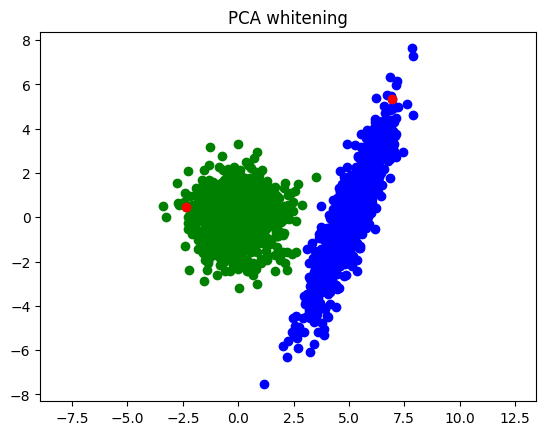

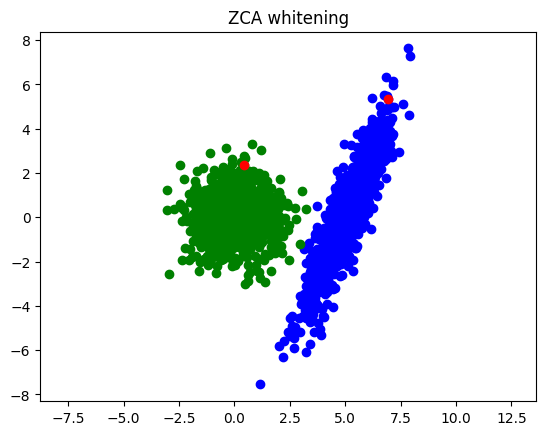

In [200]:
# 由于SVD分解是特征值分解的推广，因此下面两种实现方法等价：

def whitening(X,vec_order,method,epsilon=1e-8):
    assert type(X)==torch.Tensor
    assert X.ndim>=2
    assert vec_order in ["row","column"] # 单个样本是行向量还是列向量
    assert method in ["PCA","ZCA"]

    # 零均值化+计算协方差矩阵
    # 协方差矩阵不是计算每个样本中不同特征维度的内积，而是计算每个特征维度中不同样本的内积
    if(vec_order=="row"):
        X = X - torch.mean(X,dim=-2,keepdim=True)
        N = X.shape[-2]
        COV = (X.T @ X) / N # (Dim_feature,Dim_feature)
    else:
        X = X - torch.mean(X,dim=-1,keepdim=True)
        N = X.shape[-1]
        COV = (X @ X.T) / N
        
    # 特征值分解的方法，将COV分解为V@S@V.T
    # s,V = torch.linalg.eig(COV) # 特征值列表，特征向量的列矩阵
    # s   = s.real
    # R   = V.real

    # 奇异值分解的方法
    # 注意：由于Cov=U@S@V.T，故有V@Cov=U@S
    # U是主成分向量，S是基向量空间上的缩放变换，于是V就是将Cov旋转到主成分向量的变换
    U,s,VT = torch.linalg.svd(COV,full_matrices=True)
    R      = VT.T

    # 旋转+缩放
    s   = torch.abs(s + epsilon)
    s   = s.sign()/s.sqrt()
    S   = torch.diag(s)
    if(vec_order=="row"):
        X   = X @ R
        X   = X @ S
        Inv = torch.diag(1/s) @ R.T # 反变换时，把它乘在X的右边
    else:
        X   = R @ X
        X   = S @ X
        Inv = R.T @ torch.diag(1/s) # 反变换时，把它乘在X的左边
    # 反向旋转
    if(method=="ZCA"):
        if(vec_order=="row"):
            X = X @ R.T
            Inv = R @ Inv
        else:
            X = R.T @ X
            Inv = Inv @ R
    return X,Inv

torch.manual_seed(42)
X = torch.randn([1000,2])
X[:,1] += X[:,0] * 2 
X[:,0] += 5

Y1,Inv1 = whitening(X,"row","PCA")
Y2,Inv2 = whitening(X.T,"column","ZCA")

print("variance: {}".format(torch.var(Y1,dim=0).tolist()))
print("variance: {}".format(torch.var(Y2,dim=1).tolist()))


plt.scatter(X[:,0],X[:,1],color='b')
plt.scatter(Y1[:,0],Y1[:,1],color='g')
plt.scatter(X[0,0],X[0,1],color='r')
plt.scatter(Y1[0,0],Y1[0,1],color='r')
plt.axis("equal")
plt.title("PCA whitening")
plt.show()
plt.scatter(X[:,0],X[:,1],color='b')
plt.scatter(Y2[0,:],Y2[1,:],color='g')
plt.scatter(X[0,0],X[0,1],color='r')
plt.scatter(Y2[0,0],Y2[1,0],color='r')
plt.axis("equal")
plt.title("ZCA whitening")
plt.show()

### SVD分解的作用2：**Dewhitening**
- 在whiten并数据分析之后，如果要将结果变换回原始分布，就需要进行dewhitening
- 注意，dewhiten时只能回到减去均值后的状态，因为反变换时我们不知道最初减去了多少的均值

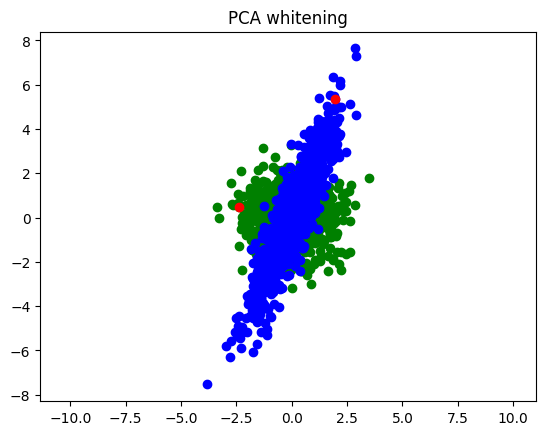

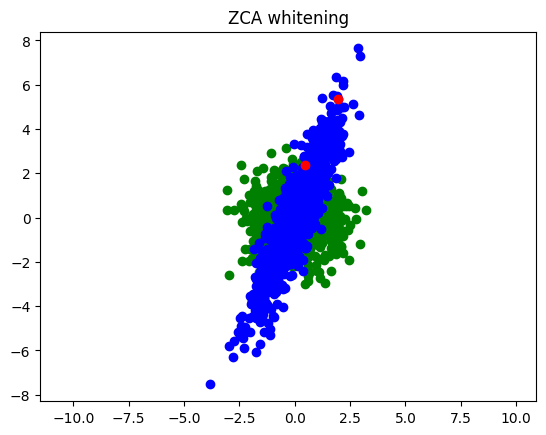

In [202]:
X1 = Y1 @ Inv1
X2 = Inv2 @ Y2

# 注意，X1和X2是行向量的矩阵，X2和Y2是列向量的矩阵
plt.scatter(Y1[:,0],Y1[:,1],color='g')
plt.scatter(X1[:,0],X1[:,1],color='b')
plt.scatter(X1[0,0],X1[0,1],color='r')
plt.scatter(Y1[0,0],Y1[0,1],color='r')
plt.axis("equal")
plt.title("PCA whitening")
plt.show()
plt.scatter(Y2[0,:],Y2[1,:],color='g')
plt.scatter(X2[0,:],X2[1,:],color='b')
plt.scatter(X2[0,0],X2[1,0],color='r')
plt.scatter(Y2[0,0],Y2[1,0],color='r')
plt.axis("equal")
plt.title("ZCA whitening")
plt.show()